# Spotify NB 5: classification
# Set up

This is a continuation of the regression notebook, as it is assumed that redefining the problem as classification will produce more robust results.

In [1]:
%reset -fs

In [1]:
import pandas as pd
import numpy as np
import json
import math
import pickle

from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier

import sklearn as skl
import sklearn.linear_model as skl_lm
import sklearn.ensemble as skl_e
import sklearn.metrics as skl_m
import sklearn.feature_selection as skl_fs
import sklearn.cluster as skl_c
import sklearn.preprocessing as skl_p
import sklearn.model_selection as skl_ms

import xgboost as xgb
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
plt.style.use('seaborn')
RSEED=np.random.seed(42)

## Data cleaning & feature engineering
The data was cleaned in the course of the EDA. Additional features were created and the new dataset was saved to a csv, that will be the starting point for this notebook. For further information on the data cleaning please refer to the respective notebook (Spotify_2019_EDA).

In [2]:
# loading cleaned data from csv
data = pd.read_csv('data/tracks_2019_cleaned.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
df=data.copy()
df.shape

(347865, 28)

## Creating classes
Due to the way the data is distributed (see EDA) we assume only the top 20% of the tracks can be considered popular.

In [4]:
# setting thershold
threshold=df['popularity'].quantile(0.8)

# initialising popular class as 0
df['popular_class'] = 0

# setting popular class = 1 where popularity is equal to or above the threshold
df.loc[df['popularity'] >= threshold, 'popular_class'] = 1  
df['popular_class'].value_counts()

0    277212
1     70653
Name: popular_class, dtype: int64

## Assigning train and test data

In [5]:
y = df['popular_class']
X = df.drop('popularity', axis=1)
X.drop(y.name, axis=1, inplace=True)
X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, y, test_size=0.3, random_state=RSEED)

## Showing model results

In [6]:
def show_classification_results(fitted_preprocessor, model, X, y):
    
    # calculate scores
    X_preprocessed = fitted_preprocessor.transform(X)
    y_predicted = model.predict(X_preprocessed)
    
    # print scores
    print("Accuracy: {:.2f}".format(skl_m.accuracy_score(y, y_predicted)))
    print("Recall: {:.2f}".format(skl_m.recall_score(y, y_predicted)))
    print("Precision: {:.2f}".format(skl_m.precision_score(y, y_predicted)))
    print("ROC AUC: {:.2f}".format(skl_m.roc_auc_score(y, y_predicted)))


    #confusion matrix
    cm = skl_m.confusion_matrix(y, y_predicted)
    cm = cm.astype('float') / cm.sum(axis=1) [:, np.newaxis] 
    
    # view with a heatmap
    plt.figure()
    sns.heatmap(cm, annot=True, annot_kws={"size":30},
                cmap='viridis', square=True, fmt='.0%')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    name=[x for x in globals() if globals()[x] is X][0]

    plt.savefig('figures/'+model.__class__.__name__+'_'+name+'.png')

## Preprocessing

In [7]:
# Defining categorical features for preprocessing
categoric_features = list(X.columns[X.dtypes == object])+ list(X.columns[X.dtypes == bool])
exclude = ['album', 'artists', 'artists_id', 'available_markets','cover_url', 'name',
           'preview_url', 'release_date', 'track_id', 'genres']
categoric_features = [x for x in categoric_features if x not in exclude]
categoric_features

['main_genres']

In [8]:
# Defining numerical features for preprocessing
numeric_features = list(X.columns[X.dtypes!=object])
exclude = list(X.columns[X.dtypes == bool])
numeric_features = [x for x in numeric_features if x not in exclude]
numeric_features

['acousticness',
 'album_track_no',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'total_album_tracks',
 'place_in_album',
 'month',
 'no_genres']

In [9]:
# Creating transforming pipes to preprocess both categorical and numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', skl_p.StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', skl_p.OneHotEncoder(drop='first'))])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

# fitting the preprocessor to X_train
fitted_preprocessor=preprocessor.fit(X_train)

# Predictive modeling baseline - Naive Bayes

## Model

In [10]:
# defining a pipe for the preprocessor and the model
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('bayes', GaussianNB())
])

#fitting the model
base_pipe.fit(X_train, y_train)
base_model = base_pipe['bayes']

## Performance on train data

Accuracy: 0.81
Recall: 0.46
Precision: 0.54
ROC AUC: 0.68


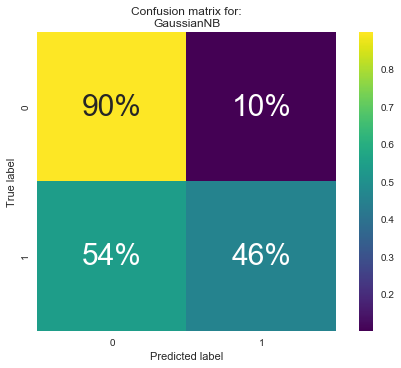

In [11]:
show_classification_results(fitted_preprocessor, base_model, X_train, y_train)

## Performance on test data

Accuracy: 0.81
Recall: 0.46
Precision: 0.53
ROC AUC: 0.68


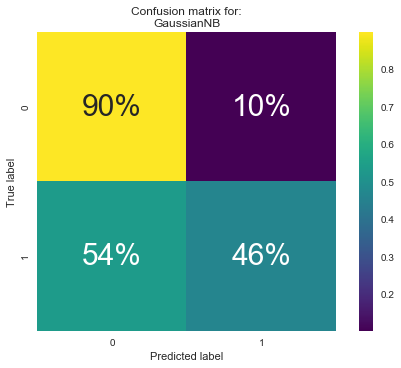

In [12]:
# show results on train data
show_classification_results(fitted_preprocessor, base_model, X_test, y_test)

# Predictive modeling

## Testing models

In [14]:
# choosing the models to be tested
models={
    'logreg': skl_lm.LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1),
    'tree': tree.DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
    'forest': skl_e.RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
    'bayes': GaussianNB(),
    'XGB' : xgb.XGBClassifier(seed=RSEED,  n_jobs=-1),
    'AdaBoost' : skl_e.AdaBoostClassifier(random_state=RSEED),
    'NN': MLPClassifier(random_state=RSEED, max_iter=100)}


In [15]:
# looping through the models and summarising results
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision', 'F1', 'ROC auc' ])
i=0

for m in models.items():
    # Building a full pipeline with our preprocessor, a scaler to balance the data and a classifier
    pipe = imbPipeline([
        ('preprocessor', preprocessor),
        ('ADASYN', ADASYN(random_state=RSEED)),
        (m[0], m[1])
    ])

    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_train_predicted = skl_ms.cross_val_predict(pipe, X_train, y_train.values.ravel(), cv=5, verbose=5, n_jobs=-1)

    # Calculating the accuracy for the LogisticRegression Classifier
    temp = pd.DataFrame({
        'Model': m[0],
        'Accuracy': skl_m.accuracy_score(y_train, y_train_predicted),
        'Recall' : skl_m.recall_score(y_train, y_train_predicted),
        'Precision': skl_m.precision_score(y_train, y_train_predicted),
        'F1': skl_m.f1_score(y_train, y_train_predicted),
        'ROC auc': skl_m.roc_auc_score(y_train, y_train_predicted)

    }, index=[i])
    i+=1

    results = pd.concat([results, temp])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.4min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.3min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.0min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

In [16]:
# show model performance
results.round(2)

,Model,Accuracy,Recall,Precision,F1,ROC auc
0,logreg,0.74,0.77,0.42,0.54,0.75
1,tree,0.68,0.76,0.36,0.49,0.71
2,forest,0.83,0.59,0.57,0.58,0.74
3,bayes,0.81,0.47,0.54,0.50,0.68
4,XGB,0.79,0.61,0.50,0.55,0.73
5,AdaBoost,0.77,0.67,0.45,0.54,0.73
6,NN,0.75,0.74,0.43,0.54,0.74


## Model optimisation

In the following the best five models will be optimised to be used in the ensuing stacked model. 

In [15]:
# define metric for optimisation
metric = 'roc_auc'

### Randomized search on forest

In [18]:
# Building a full pipeline with our preprocessor, a scaler to balance the data and a classifier
forest_pipe = imbPipeline([
    ('preprocessor', preprocessor),
    ('ADASYN', ADASYN(random_state=RSEED)),
    ('forest', skl_e.RandomForestClassifier(random_state=RSEED, n_jobs=-1))
    ])

# Defining the hyperparameters to be tested
forest_param_grid = {
    'forest__min_samples_split': [3, 5, 10],
    'forest__n_estimators' : [100, 300, 500],
    'forest__max_depth': [1, 3, 5, 10],
    'forest__max_features': [3, 5, 7, 10, 20, 30]}

In [19]:
# tuning hyperparameters
forest_rgrid = skl_ms.RandomizedSearchCV(forest_pipe, param_distributions = forest_param_grid,  cv=3, 
                                            scoring=metric, verbose=10, n_jobs=-1, random_state = RSEED)
forest_rgrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 46.6min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 50.0min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['acousticness',
                                                                                'album_track_no',
                                                                                'danceability',
                                                                            

In [31]:
# saving the best model
print("Best parameters:\n{}".format(forest_rgrid.best_params_))
forest_best_model = forest_rgrid.best_estimator_['forest']
pickle.dump(forest_best_model, open('Pickles/forest_best_model.pkl', 'wb'))

Best parameters:
{'forest__n_estimators': 100, 'forest__min_samples_split': 5, 'forest__max_features': 7, 'forest__max_depth': 10}


#### Performance on train data

Accuracy: 0.77
Recall: 0.75
Precision: 0.47
ROC AUC: 0.76


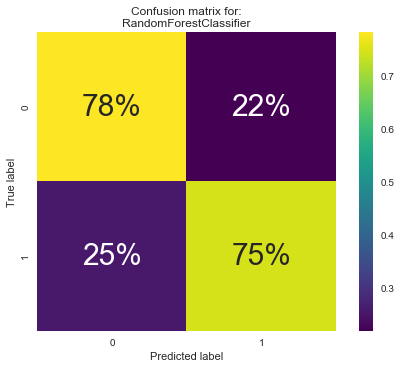

In [21]:
show_classification_results(fitted_preprocessor, forest_best_model, X_train, y_train)

#### Performance on test data

Accuracy: 0.77
Recall: 0.74
Precision: 0.46
ROC AUC: 0.76


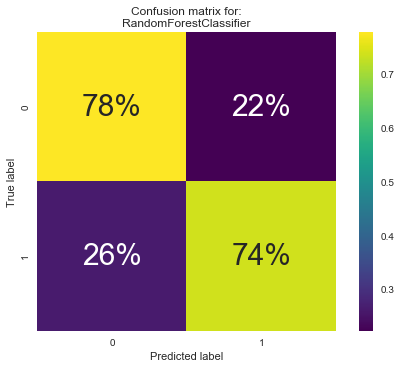

In [22]:
show_classification_results(fitted_preprocessor, forest_best_model, X_test, y_test)

### Randomized search on logistic regression

In [23]:
# Building a full pipeline with our preprocessor, a scaler to balance the data and a classifier
logreg_pipe = imbPipeline([
    ('preprocessor', preprocessor),
    ('ADASYN', ADASYN(random_state=RSEED)),
    ('logreg', skl_lm.LogisticRegression(random_state=RSEED, n_jobs=-1))
    ])

# Defining the hyperparameters to be tested
logreg_param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C' : np.logspace(0.0001, 4, 10),
}


In [24]:
# tuning hyperparameters
logreg_rgrid = skl_ms.RandomizedSearchCV(logreg_pipe, param_distributions = logreg_param_grid,  cv=3, 
                                            scoring=metric, verbose=10, n_jobs=-1, random_state = RSEED)
logreg_rgrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 85.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 89.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 98.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 106.6min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 109.4min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['acousticness',
                                                                                'album_track_no',
                                                                                'danceability',
                                                                            

In [32]:
# saving the best model
print("Best parameters:\n{}".format(logreg_rgrid.best_params_))
logreg_best_model = logreg_rgrid.best_estimator_['logreg']
pickle.dump(logreg_best_model, open('Pickles/logreg_best_model.pkl', 'wb'))

Best parameters:
{'logreg__penalty': 'l2', 'logreg__C': 3593.905610111581}


#### Performance on train data

Accuracy: 0.74
Recall: 0.77
Precision: 0.42
ROC AUC: 0.75


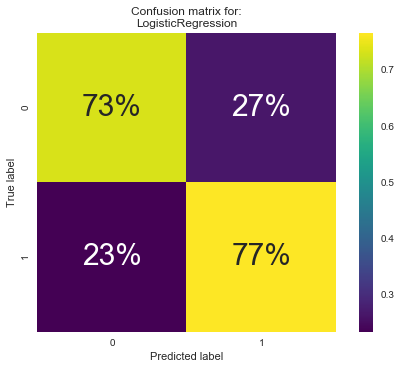

In [26]:
show_classification_results(fitted_preprocessor, logreg_best_model, X_train, y_train)

#### Performance on test data

Accuracy: 0.74
Recall: 0.77
Precision: 0.42
ROC AUC: 0.75


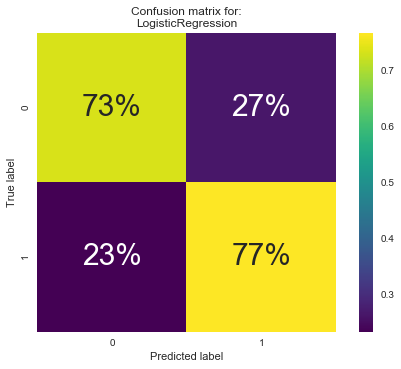

In [27]:
show_classification_results(fitted_preprocessor, logreg_best_model, X_test, y_test)

### Randomized search on ADABoost

In [33]:
# Building a full pipeline with our preprocessor, a scaler to balance the data and a classifier
ADA_pipe = imbPipeline([
        ('preprocessor', preprocessor),
        ('ADASYN', ADASYN(random_state=RSEED)),
        ('AdaBoost', skl_e.AdaBoostClassifier(random_state=RSEED))
    ])

# Defining the hyperparameters to be tested
ADA_param_grid = {
    'AdaBoost__n_estimators':[50, 100, 150, 200, 250, 300],                
    'AdaBoost__learning_rate':np.logspace(0.0001, 1, 5)}  


In [34]:
# tuning hyperparameters
ADA_rgrid = skl_ms.RandomizedSearchCV(ADA_pipe, param_distributions = ADA_param_grid,  cv=3, 
                                            scoring=metric, verbose=10, n_jobs=-1, random_state = RSEED)
ADA_rgrid .fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 53.2min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 57.0min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['acousticness',
                                                                                'album_track_no',
                                                                                'danceability',
                                                                            

In [35]:
# saving the best model
print("Best parameters:\n{}".format(ADA_rgrid.best_params_))
ADA_best_model = ADA_rgrid.best_estimator_['AdaBoost']
pickle.dump(ADA_best_model, open('Pickles/ADA_best_model.pkl', 'wb'))

Best parameters:
{'AdaBoost__n_estimators': 200, 'AdaBoost__learning_rate': 1.778586534531975}


#### Performance on train data

Accuracy: 0.83
Recall: 0.44
Precision: 0.60
ROC AUC: 0.68


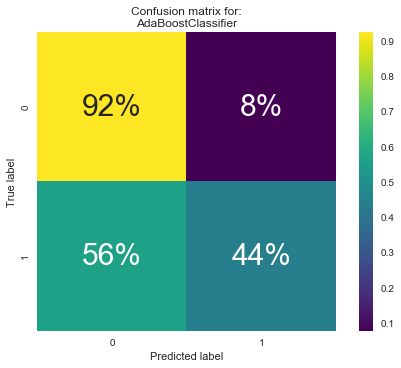

In [43]:
show_classification_results(fitted_preprocessor, ADA_best_model, X_train, y_train)

#### Performance on test data

Accuracy: 0.83
Recall: 0.44
Precision: 0.60
ROC AUC: 0.68


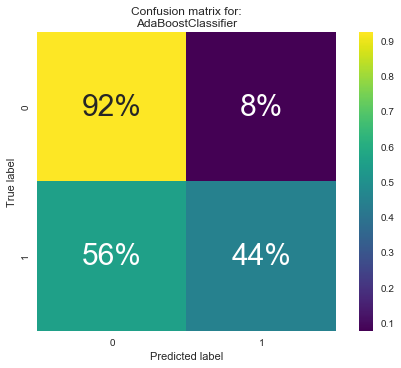

In [37]:
show_classification_results(fitted_preprocessor, ADA_best_model, X_test, y_test)

### Randomized search on XGBoost

In [16]:
# Building a full pipeline with our preprocessor, a scaler to balance the data and the classifier
XGB_pipe = imbPipeline([
        ('preprocessor', preprocessor),
        ('ADASYN', ADASYN(random_state=RSEED)),
        ('XGB', xgb.XGBClassifier(seed=RSEED, n_jobs=-1)) 
    ])

# Defining the hyperparameters to be tested
XGB_param_grid = {
    'XGB__max_depth':[1, 2, 3, 5, None],
    'XGB__learning_rate':[0.1, 0.3, 0.5, 0.8, 1],
    'XGB__n_estimators':[100, 250, 200, 500, 1000]
    } 

In [17]:
# tuning hyperparameters
XGB_rgrid = skl_ms.RandomizedSearchCV(XGB_pipe, param_distributions = XGB_param_grid,  cv=3, 
                                            scoring=metric, verbose=10, n_jobs=-1, random_state = RSEED)
XGB_rgrid .fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 69.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 94.7min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 103.7min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['acousticness',
                                                                                'album_track_no',
                                                                                'danceability',
                                                                            

In [18]:
# saving the best model
print("Best parameters:\n{}".format(XGB_rgrid.best_params_))
XGB_best_model = XGB_rgrid.best_estimator_['XGB']
pickle.dump(XGB_best_model, open('Pickles/XGB_best_model.pkl', 'wb'))

Best parameters:
{'XGB__n_estimators': 1000, 'XGB__max_depth': 3, 'XGB__learning_rate': 0.1}


#### Performance on train data

Accuracy: 0.84
Recall: 0.53
Precision: 0.63
ROC AUC: 0.72


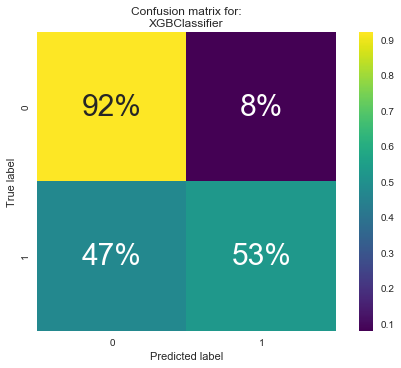

In [19]:
show_classification_results(fitted_preprocessor, XGB_best_model, X_train, y_train)

#### Performance on test data

Accuracy: 0.84
Recall: 0.52
Precision: 0.62
ROC AUC: 0.72


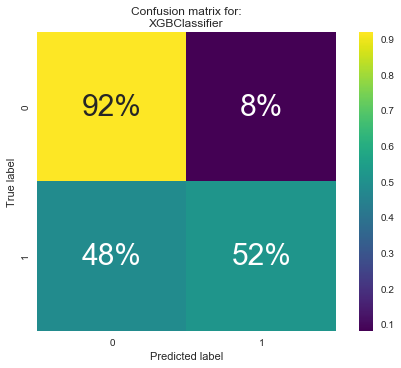

In [20]:
show_classification_results(fitted_preprocessor, XGB_best_model, X_test, y_test)

### Randomized search on neural network

In [21]:
# Building a full pipeline with our preprocessor, a scaler to balance the data and the classifier
NN_pipe = imbPipeline([
        ('preprocessor', preprocessor),
        ('ADASYN', ADASYN(random_state=RSEED)),
        ('NN', MLPClassifier(random_state=RSEED, max_iter=100))
    ])

# Defining the hyperparameters to be tested
NN_param_grid = {
    'NN__hidden_layer_sizes': [(10,30,10),(20,)],
    'NN__activation': ['tanh', 'relu'],
    'NN__solver': ['sgd', 'adam'],
    'NN__alpha': [0.0001, 0.05],
    'NN__learning_rate': ['constant','adaptive'],
    } 

In [22]:
# tuning hyperparameters
NN_rgrid = skl_ms.RandomizedSearchCV(NN_pipe, param_distributions = NN_param_grid,  cv=3, 
                                            scoring=metric, verbose=10, n_jobs=-1, random_state = RSEED)
NN_rgrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 54.4min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 59.2min finished
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['acousticness',
                                                                                'album_track_no',
                                                                                'danceability',
                                                                            

In [23]:
# saving the best model
print("Best parameters:\n{}".format(NN_rgrid.best_params_))
NN_best_model = NN_rgrid.best_estimator_['NN']
pickle.dump(NN_best_model, open('Pickles/NN_best_model.pkl', 'wb'))

Best parameters:
{'NN__solver': 'sgd', 'NN__learning_rate': 'adaptive', 'NN__hidden_layer_sizes': (20,), 'NN__alpha': 0.05, 'NN__activation': 'tanh'}


#### Performance on train data

Accuracy: 0.74
Recall: 0.79
Precision: 0.43
ROC AUC: 0.76


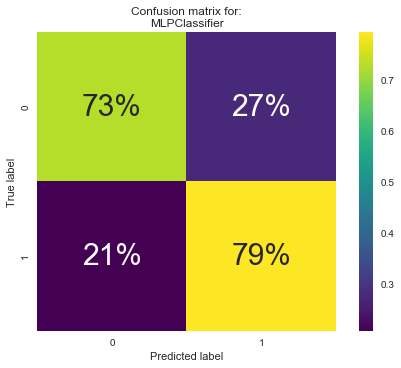

In [24]:
show_classification_results(fitted_preprocessor, NN_best_model, X_train, y_train)

#### Performance on test data

Accuracy: 0.74
Recall: 0.79
Precision: 0.42
ROC AUC: 0.76


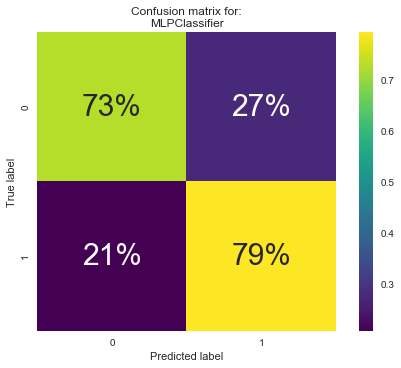

In [25]:
show_classification_results(fitted_preprocessor, NN_best_model, X_test, y_test)

## Stacked model

In [27]:
# Reloading the models from pickle, so the notebook does not have to be rerun completely
forest_best_model = pickle.load(open('Pickles/forest_best_model.pkl', 'rb'))
logreg_best_model = pickle.load(open('Pickles/logreg_best_model.pkl', 'rb'))
ADA_best_model = pickle.load(open('Pickles/ADA_best_model.pkl', 'rb'))
XGB_best_model = pickle.load(open('Pickles/XGB_best_model.pkl', 'rb'))
NN_best_model = pickle.load(open('Pickles/NN_best_model.pkl', 'rb'))


In [28]:
# Defining the models for the base layer
base_models=models={
    'logreg': logreg_best_model,
    'forest': forest_best_model,
    'XGB' : XGB_best_model,
    'AdaBoost' : ADA_best_model,
    'NN': NN_best_model
}

In [29]:
# making a prediction with a stacking ensemble
# defining the base models
level0 = list(base_models.items())

# defining meta learner model
level1 = skl_lm.LogisticRegression()

# defining the stacking ensemble
stack = StackingClassifier(estimators=level0, final_estimator=level1, cv=3, n_jobs=-1)

# build pipe
stacked_pipe =  imbPipeline([
    ('preprocessor', preprocessor),
    ('ADASYN', ADASYN(random_state=RSEED)),
    ('stack', stack)])

# cross-validation scores
scores = skl_ms.cross_val_score(stacked_pipe, X_train, y_train.values.ravel(), scoring=metric, cv=3, n_jobs=-1, verbose=5)


# make a prediction for one example
y_train_predicted = skl_ms.cross_val_predict(stacked_pipe, X_train, y_train.values.ravel(), cv=3, n_jobs=-1, verbose=5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 52.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 52.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 53.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 53.8min finished


In [30]:
# fitting and saving the model
stacked_pipe.fit(X_train, y_train)
stacked_model = stacked_pipe['stack']
pickle.dump(stacked_model, open('Pickles/stacked_model.pkl', 'wb'))

/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterati

In [31]:
print("Cross-validation scores"+str(scores))

Cross-validation scores[0.8225829  0.84104211 0.82574483]


### Performance on train data

Accuracy: 0.81
Recall: 0.69
Precision: 0.53
ROC AUC: 0.76


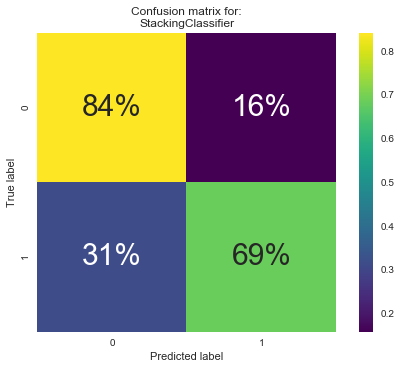

In [32]:
show_classification_results(fitted_preprocessor, stacked_model, X_train, y_train)

### Performance on test data

Accuracy: 0.81
Recall: 0.68
Precision: 0.52
ROC AUC: 0.76


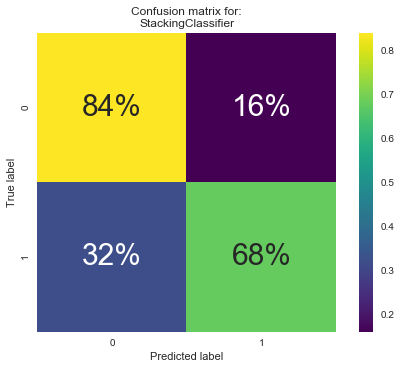

In [33]:
show_classification_results(fitted_preprocessor, stacked_model, X_test, y_test)

## Feature importance

              features  importance
0                month    0.177643
1       album_track_no    0.129102
2            no_genres    0.124972
3   total_album_tracks    0.062717
4             explicit    0.061386
5     instrumentalness    0.044494
6          duration_ms    0.034274
7       place_in_album    0.021296
8          speechiness    0.015775
9          main_genres    0.013950
10        acousticness    0.013914
11            loudness    0.012644
12      time_signature    0.012153
13               tempo    0.011372
14            liveness    0.010317
15              energy    0.006439
16        danceability    0.006165


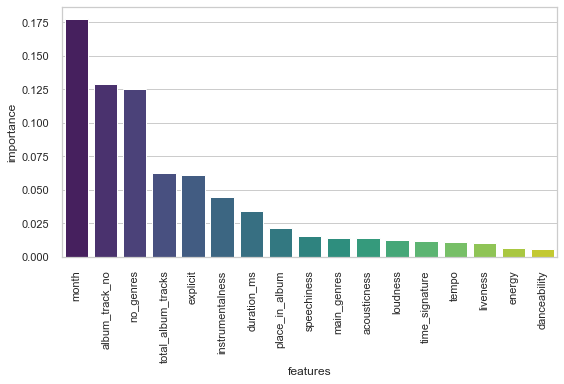

In [34]:
# feature importance
imp = pd.DataFrame([x for x in zip(numeric_features+categoric_features,XGB_best_model.feature_importances_)])
imp.columns = ['features', 'importance']
imp = imp.sort_values(['importance'], ascending=False).reset_index(drop=True)
print(imp)
# plot
sns.set(style="whitegrid")
chart=sns.barplot(x='features',y ='importance', data = imp, palette='viridis', order = imp['features'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);
plt.tight_layout()
plt.savefig('figures/feature_imp_classification.png')

## Results
When comparing the results of the different models AdaBoost fails is the only model that fails to outperform the Naive Bayes baseline model in terms of ROC AUC (0.68 for both). All other models show ROC AUC values between 0.72 and 0.76 although they vary in precision and recall. 
All models show consistent performance on the train and the test data.

The random forest has a very balanced confusion matrix and scores reasonably overall, which makes it the most suitable model. If we however want to emphasise the certainty of a songs popularity XGBoost provides the most reliable outcomes, as indicated by it high precision score.

The stacked model fails to outperform the individual models, not justifying adding this level of complexity.

In [47]:
# chosing the best models and saving them
balanced_model = forest_best_model
strict_model = XGB_best_model

pickle.dump(preprocessor, open('Pickles/fitted_preprocessor.pkl', 'wb'))
pickle.dump(balanced_model, open('Pickles/balanced_model.pkl', 'wb'))
pickle.dump(strict_model, open('Pickles/strict_model.pkl', 'wb'))

### Test for app

In [74]:
info_entered = df.sample(1).T.to_dict()
info_entered = info_entered[list(info_entered.keys())[0]]

In [75]:
info_entered = pd.DataFrame(columns=info_entered.keys()).append(info_entered, ignore_index = True)
info_entered.drop('popularity', axis=1, inplace=True)
info_entered

,acousticness,album,album_track_no,artists,artists_id,available_markets,cover_url,danceability,duration_ms,energy,...,tempo,time_signature,total_album_tracks,track_id,genres,place_in_album,month,main_genres,no_genres,popular_class
0,0.00224,"Remember Why You Started (feat. Alpha, Jones 2...",1,Fearless Motivation,1FhamVtJlNqaekPnwxQpbk,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b27316e284...,0.404,230000,0.784,...,170.09,4.0,1,6NgP0t2l8f48eLNX5T9aFy,['motivation'],1.0,5.0,other,1,1


In [76]:
info_preprocessed = fitted_preprocessor.transform(info_entered)
print('Predicted popularity class by balanced model:\n{:.0f}'.format(int(balanced_model.predict(info_preprocessed))))
print('Predicted popularity class by strict model:\n{:.0f}'.format(int(strict_model.predict(info_preprocessed))))


Predicted popularity class by balanced model:
1
Predicted popularity class by strict model:
1


/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
